In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import v2
from torch.utils.data import DataLoader

import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from catalyst import dl, metrics
from catalyst.contrib.losses import DiceLoss, IoULoss
from catalyst.contrib.optimizers import AdamP, Lamb

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve

import datetime
import random

import sys
import os
module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(os.path.join(module_path, "datasets"))

from InriaImagesDataset import ImagesDataset
from SegmentationCustomRunner import SegmentationCustomRunner
from Experiment import Experiment

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DATA_DIR = os.path.join(os.path.abspath('..'), 'data', 'PreprocessedAerialImageDataset')

TRAIN_DIR = os.path.join(DATA_DIR, 'train')

today = datetime.datetime.now()

# Загрузка данных

In [3]:
df_all = pd.read_csv(os.path.join(TRAIN_DIR, 'labels.csv'))
df_all

,image,mask
0,images/austin10_image_0.jpg,gt/austin10_mask_0.png
1,images/austin10_image_1.jpg,gt/austin10_mask_1.png
2,images/austin10_image_10.jpg,gt/austin10_mask_10.png
3,images/austin10_image_11.jpg,gt/austin10_mask_11.png
4,images/austin10_image_12.jpg,gt/austin10_mask_12.png
...,...,...
17995,images/vienna9_image_95.jpg,gt/vienna9_mask_95.png
17996,images/vienna9_image_96.jpg,gt/vienna9_mask_96.png
17997,images/vienna9_image_97.jpg,gt/vienna9_mask_97.png
17998,images/vienna9_image_98.jpg,gt/vienna9_mask_98.png


In [4]:
X, y = df_all['image'], df_all['mask']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

In [5]:
df_train, df_valid = pd.concat([X_train, y_train], axis=1), pd.concat([X_valid, y_valid], axis=1)

In [6]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(),
        A.RGBShift(),
        A.Blur(),
        A.GaussNoise(var_limit=3),
        A.ElasticTransform(),
        A.MaskDropout((1, 10)),
        ToTensorV2()
    ],
    is_check_shapes=False
)

val_transform = A.Compose(
    [   
        A.Resize(256, 256),
        ToTensorV2()
    ],
    is_check_shapes=False
)

In [7]:
ds_train = ImagesDataset(df_train, TRAIN_DIR, transform=train_transform)
ds_val = ImagesDataset(df_valid, TRAIN_DIR, transform=val_transform)

In [8]:
ds_train[0]['image'].unique()

tensor([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
         87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
        185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 1

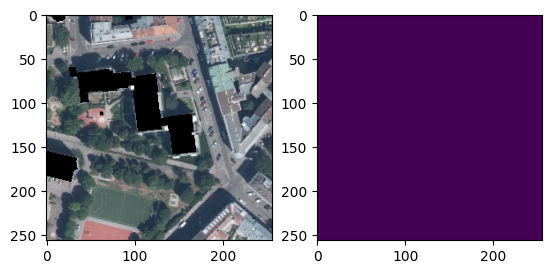

In [9]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(ds_train[0]['image'].permute(1, 2, 0))
ax[1].imshow(ds_train[0]['mask'].squeeze())

In [10]:
loaders = {"train": DataLoader(ds_train, batch_size=8), 'valid': DataLoader(ds_val, batch_size=16)}

# Подготовка к обучению модели

In [11]:
#model = smp.Unet(encoder_name='efficientnet-b0', aux_params=aux_params).to(DEVICE)
#model = smp.Unet(encoder_name='efficientnet-b0').to(DEVICE)
#encoder_name = 'timm-mobilenetv3_small_075'
encoder_name = 'mit_b0'
model = smp.Unet(encoder_name=encoder_name, activation='sigmoid', classes=1).to(DEVICE)
model

Unet(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=32, o

In [12]:
criterion = IoULoss()
#criterion = DiceLoss()
#criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()

In [13]:
lr = 1e-6

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7)

# Обучение модели

In [16]:
num_epochs = 15

In [17]:
exp_name = f"{encoder_name}-{today.strftime('%d-%m-%Y')}-lr-{lr}-{num_epochs}-epochs-augmentations"

In [18]:
init_config = {
    "name": exp_name,
    "model": model,
    "runner_config": {
        "engine": dl.GPUEngine("cuda:0"),
        "criterion": criterion,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "loaders": loaders,
        "num_epochs": num_epochs,
        "callbacks": [
            dl.BackwardCallback(metric_key="loss"),
            dl.SchedulerCallback(mode="epoch"),
            dl.IOUCallback(input_key="mask_pred", target_key="mask_target"),
            dl.DiceCallback(input_key="mask_pred", target_key="mask_target"),
            dl.TrevskyCallback(input_key="mask_pred", target_key="mask_target", alpha=0.2),
            dl.PrecisionRecallF1SupportCallback(
                input_key="label_pred", target_key="label_target", num_classes=1
            ),
            dl.OptimizerCallback(
                metric_key="loss",
            ),
        ],
        "valid_loader": "valid",
        "valid_metric": "iou",
        "minimize_valid_metric": False,
        "verbose": True,
        "load_best_on_end": True
    },
    "metrics_to_plot": ["loss", "iou", "dice"],
    "eval_config": {
        "callbacks": [
            dl.IOUCallback(input_key="mask_pred", target_key="mask_target"),
            dl.DiceCallback(input_key="mask_pred", target_key="mask_target"),
            dl.TrevskyCallback(input_key="mask_pred", target_key="mask_target", alpha=0.2),
        ],
    }
}

In [19]:
experiment = Experiment(init_config)

1/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (1/15) dice: 0.24151745438575745 | dice/_macro: 0.24151745438575745 | dice/_micro: 0.24151745438575745 | f1/_macro: 0.8193777489578896 | f1/_micro: 0.8193777489578896 | f1/_weighted: 0.8193777489578896 | iou: 0.13734424114227295 | iou/_macro: 0.13734424114227295 | iou/_micro: 0.13734424114227295 | loss: 0.8647609704335522 | loss/mean: 0.8647609704335522 | loss/std: 0.04946304652436192 | lr: 1e-06 | momentum: 0.9 | precision/_macro: 0.9190878971132092 | precision/_micro: 0.9190878971132092 | precision/_weighted: 0.9190878971132092 | recall/_macro: 0.7391929828546706 | recall/_micro: 0.7391929828546706 | recall/_weighted: 0.7391929828546706 | trevsky: 0.1817813366651535 | trevsky/_macro: 0.1817813366651535 | trevsky/_micro: 0.1817813366651535


f:\housing-segmentation-in-amur-river-area\env\lib\site-packages\accelerate\utils\dataclasses.py:522: FutureWarning: The `TPU` of `<enum 'DistributedType'>` is deprecated and will be removed in v1.0.0. Please use the `XLA` instead.
  warnings.warn(


1/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (1/15) dice: 0.3618839979171753 | dice/_macro: 0.3618839979171753 | dice/_micro: 0.3618839979171753 | f1/_macro: 0.8157934677677119 | f1/_micro: 0.8157934677677119 | f1/_weighted: 0.8157934677677119 | iou: 0.2209147959947586 | iou/_macro: 0.2209147959947586 | iou/_micro: 0.2209147959947586 | loss: 0.7827908311420015 | loss/mean: 0.7827908311420015 | loss/std: 0.04114326629827754 | lr: 1e-06 | momentum: 0.9 | precision/_macro: 0.9514330236549615 | precision/_micro: 0.9514330236549615 | precision/_weighted: 0.9514330236549615 | recall/_macro: 0.7140102862108288 | recall/_micro: 0.7140102862108288 | recall/_weighted: 0.7140102862108288 | trevsky: 0.2810472548007965 | trevsky/_macro: 0.2810472548007965 | trevsky/_micro: 0.2810472548007965
* Epoch (1/15) lr: 9.997779521645791e-07 | momentum: 0.9


2/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (2/15) dice: 0.3229295611381531 | dice/_macro: 0.3229295611381531 | dice/_micro: 0.3229295611381531 | f1/_macro: 0.8504291064486142 | f1/_micro: 0.8504291064486142 | f1/_weighted: 0.8504291064486142 | iou: 0.1925557553768158 | iou/_macro: 0.1925557553768158 | iou/_micro: 0.1925557553768158 | loss: 0.8101565371972534 | loss/mean: 0.8101565371972534 | loss/std: 0.06209496336063258 | lr: 9.997779521645791e-07 | momentum: 0.9 | precision/_macro: 0.9630135948353559 | precision/_micro: 0.9630135948353559 | precision/_weighted: 0.9630135948353559 | recall/_macro: 0.7614213041282021 | recall/_micro: 0.7614213041282021 | recall/_weighted: 0.7614213041282021 | trevsky: 0.24444371461868286 | trevsky/_macro: 0.24444371461868286 | trevsky/_micro: 0.24444371461868286


2/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (2/15) dice: 0.42461249232292175 | dice/_macro: 0.42461249232292175 | dice/_micro: 0.42461249232292175 | f1/_macro: 0.814017503935528 | f1/_micro: 0.814017503935528 | f1/_weighted: 0.814017503935528 | iou: 0.26952892541885376 | iou/_macro: 0.26952892541885376 | iou/_micro: 0.26952892541885376 | loss: 0.7348150155809193 | loss/mean: 0.7348150155809193 | loss/std: 0.043559013574915706 | lr: 9.997779521645791e-07 | momentum: 0.9 | precision/_macro: 0.9785612414320216 | precision/_micro: 0.9785612414320216 | precision/_weighted: 0.9785612414320216 | recall/_macro: 0.6968512376879423 | recall/_micro: 0.6968512376879423 | recall/_weighted: 0.6968512376879423 | trevsky: 0.32823747396469116 | trevsky/_macro: 0.32823747396469116 | trevsky/_micro: 0.32823747396469116
* Epoch (2/15) lr: 9.99112027792722e-07 | momentum: 0.9


3/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (3/15) dice: 0.37260323762893677 | dice/_macro: 0.37260323762893677 | dice/_micro: 0.37260323762893677 | f1/_macro: 0.8690549671120248 | f1/_micro: 0.8690549671120248 | f1/_weighted: 0.8690549671120248 | iou: 0.22895659506320953 | iou/_macro: 0.22895659506320953 | iou/_micro: 0.22895659506320953 | loss: 0.7745504718533264 | loss/mean: 0.7745504718533264 | loss/std: 0.07288724090843628 | lr: 9.99112027792722e-07 | momentum: 0.9 | precision/_macro: 0.9739173889720838 | precision/_micro: 0.9739173889720838 | precision/_weighted: 0.9739173889720838 | recall/_macro: 0.7845868327288644 | recall/_micro: 0.7845868327288644 | recall/_weighted: 0.7845868327288644 | trevsky: 0.28485390543937683 | trevsky/_macro: 0.28485390543937683 | trevsky/_micro: 0.28485390543937683


3/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (3/15) dice: 0.4611093997955322 | dice/_macro: 0.4611093997955322 | dice/_micro: 0.4611093997955322 | f1/_macro: 0.8436616192100345 | f1/_micro: 0.8436616192100345 | f1/_weighted: 0.8436616192100345 | iou: 0.2996375560760498 | iou/_macro: 0.2996375560760498 | iou/_micro: 0.2996375560760498 | loss: 0.7051937128172983 | loss/mean: 0.7051937128172983 | loss/std: 0.04514235911829493 | lr: 9.99112027792722e-07 | momentum: 0.9 | precision/_macro: 0.9807211440123995 | precision/_micro: 0.9807211440123995 | precision/_weighted: 0.9807211440123995 | recall/_macro: 0.7402214477770019 | recall/_micro: 0.7402214477770019 | recall/_weighted: 0.7402214477770019 | trevsky: 0.36091241240501404 | trevsky/_macro: 0.36091241240501404 | trevsky/_micro: 0.36091241240501404
* Epoch (3/15) lr: 9.980028840713857e-07 | momentum: 0.9


4/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (4/15) dice: 0.4064894914627075 | dice/_macro: 0.4064894914627075 | dice/_micro: 0.4064894914627075 | f1/_macro: 0.8871360076371516 | f1/_micro: 0.8871360076371516 | f1/_weighted: 0.8871360076371516 | iou: 0.2550905644893646 | iou/_macro: 0.2550905644893646 | iou/_micro: 0.2550905644893646 | loss: 0.7491121246196621 | loss/mean: 0.7491121246196621 | loss/std: 0.0786128112710019 | lr: 9.980028840713857e-07 | momentum: 0.9 | precision/_macro: 0.9764484654181788 | precision/_micro: 0.9764484654181788 | precision/_weighted: 0.9764484654181788 | recall/_macro: 0.8128009254029183 | recall/_micro: 0.8128009254029183 | recall/_weighted: 0.8128009254029183 | trevsky: 0.31409353017807007 | trevsky/_macro: 0.31409353017807007 | trevsky/_micro: 0.31409353017807007


4/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (4/15) dice: 0.48516082763671875 | dice/_macro: 0.48516082763671875 | dice/_micro: 0.48516082763671875 | f1/_macro: 0.8620531951900471 | f1/_micro: 0.8620531951900471 | f1/_weighted: 0.8620531951900471 | iou: 0.32027220726013184 | iou/_macro: 0.32027220726013184 | iou/_micro: 0.32027220726013184 | loss: 0.6849106908904183 | loss/mean: 0.6849106908904183 | loss/std: 0.0462248013532978 | lr: 9.980028840713857e-07 | momentum: 0.9 | precision/_macro: 0.9819059782010711 | precision/_micro: 0.9819059782010711 | precision/_weighted: 0.9819059782010711 | recall/_macro: 0.7682841618478808 | recall/_micro: 0.7682841618478808 | recall/_weighted: 0.7682841618478808 | trevsky: 0.38268908858299255 | trevsky/_macro: 0.38268908858299255 | trevsky/_micro: 0.38268908858299255
* Epoch (4/15) lr: 9.96451615591515e-07 | momentum: 0.9


5/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (5/15) dice: 0.4328320026397705 | dice/_macro: 0.4328320026397705 | dice/_micro: 0.4328320026397705 | f1/_macro: 0.9015209959753128 | f1/_micro: 0.9015209959753128 | f1/_weighted: 0.9015209959753128 | iou: 0.27618736028671265 | iou/_macro: 0.27618736028671265 | iou/_micro: 0.27618736028671265 | loss: 0.7287708167499962 | loss/mean: 0.7287708167499962 | loss/std: 0.08411613398317232 | lr: 9.96451615591515e-07 | momentum: 0.9 | precision/_macro: 0.9768817923287564 | precision/_micro: 0.9768817923287564 | precision/_weighted: 0.9768817923287564 | recall/_macro: 0.8369633305598088 | recall/_micro: 0.8369633305598088 | recall/_weighted: 0.8369633305598088 | trevsky: 0.3381301760673523 | trevsky/_macro: 0.3381301760673523 | trevsky/_micro: 0.3381301760673523


5/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (5/15) dice: 0.5105515122413635 | dice/_macro: 0.5105515122413635 | dice/_micro: 0.5105515122413635 | f1/_macro: 0.882919122931839 | f1/_micro: 0.882919122931839 | f1/_weighted: 0.882919122931839 | iou: 0.34277886152267456 | iou/_macro: 0.34277886152267456 | iou/_micro: 0.34277886152267456 | loss: 0.6628394859102033 | loss/mean: 0.6628394859102033 | loss/std: 0.04720809260540281 | lr: 9.96451615591515e-07 | momentum: 0.9 | precision/_macro: 0.9810748502980925 | precision/_micro: 0.9810748502980925 | precision/_weighted: 0.9810748502980925 | recall/_macro: 0.8026260499601146 | recall/_micro: 0.8026260499601146 | recall/_weighted: 0.8026260499601146 | trevsky: 0.4080733358860016 | trevsky/_macro: 0.4080733358860016 | trevsky/_micro: 0.4080733358860016
* Epoch (5/15) lr: 9.944597532678119e-07 | momentum: 0.9


6/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (6/15) dice: 0.45446228981018066 | dice/_macro: 0.45446228981018066 | dice/_micro: 0.45446228981018066 | f1/_macro: 0.9123127432364617 | f1/_micro: 0.9123127432364617 | f1/_weighted: 0.9123127432364617 | iou: 0.294048011302948 | iou/_macro: 0.294048011302948 | iou/_micro: 0.294048011302948 | loss: 0.711635056195436 | loss/mean: 0.711635056195436 | loss/std: 0.08837017601318573 | lr: 9.944597532678119e-07 | momentum: 0.9 | precision/_macro: 0.9765113370404119 | precision/_micro: 0.9765113370404119 | precision/_weighted: 0.9765113370404119 | recall/_macro: 0.8560433925152082 | recall/_micro: 0.8560433925152082 | recall/_weighted: 0.8560433925152082 | trevsky: 0.3588010370731354 | trevsky/_macro: 0.3588010370731354 | trevsky/_micro: 0.3588010370731354


6/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (6/15) dice: 0.5246906876564026 | dice/_macro: 0.5246906876564026 | dice/_micro: 0.5246906876564026 | f1/_macro: 0.8860693283779745 | f1/_micro: 0.8860693283779745 | f1/_weighted: 0.8860693283779745 | iou: 0.3556479513645172 | iou/_macro: 0.3556479513645172 | iou/_micro: 0.3556479513645172 | loss: 0.6500745567745634 | loss/mean: 0.6500745567745634 | loss/std: 0.04738710996774236 | lr: 9.944597532678119e-07 | momentum: 0.9 | precision/_macro: 0.9834001840886178 | precision/_micro: 0.9834001840886178 | precision/_weighted: 0.9834001840886178 | recall/_macro: 0.806277944508111 | recall/_micro: 0.806277944508111 | recall/_weighted: 0.806277944508111 | trevsky: 0.4199364483356476 | trevsky/_macro: 0.4199364483356476 | trevsky/_micro: 0.4199364483356476
* Epoch (6/15) lr: 9.9202926282791e-07 | momentum: 0.9


7/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (7/15) dice: 0.4711814820766449 | dice/_macro: 0.4711814820766449 | dice/_micro: 0.4711814820766449 | f1/_macro: 0.9207241625695997 | f1/_micro: 0.9207241625695997 | f1/_weighted: 0.9207241625695997 | iou: 0.30819976329803467 | iou/_macro: 0.30819976329803467 | iou/_micro: 0.30819976329803467 | loss: 0.6979697923660283 | loss/mean: 0.6979697923660283 | loss/std: 0.09067177725996128 | lr: 9.9202926282791e-07 | momentum: 0.9 | precision/_macro: 0.9766077650290002 | precision/_micro: 0.9766077650290002 | precision/_weighted: 0.9766077650290002 | recall/_macro: 0.8708988783550504 | recall/_micro: 0.8708988783550504 | recall/_weighted: 0.8708988783550504 | trevsky: 0.37503668665885925 | trevsky/_macro: 0.37503668665885925 | trevsky/_micro: 0.37503668665885925


7/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (7/15) dice: 0.5399703979492188 | dice/_macro: 0.5399703979492188 | dice/_micro: 0.5399703979492188 | f1/_macro: 0.8959277518868107 | f1/_micro: 0.8959277518868107 | f1/_weighted: 0.8959277518868107 | iou: 0.36983522772789 | iou/_macro: 0.36983522772789 | iou/_micro: 0.36983522772789 | loss: 0.6361185246573551 | loss/mean: 0.6361185246573551 | loss/std: 0.04799178579333966 | lr: 9.9202926282791e-07 | momentum: 0.9 | precision/_macro: 0.9830880754420684 | precision/_micro: 0.9830880754420684 | precision/_weighted: 0.9830880754420684 | recall/_macro: 0.8229723580434558 | recall/_micro: 0.8229723580434558 | recall/_weighted: 0.8229723580434558 | trevsky: 0.435293048620224 | trevsky/_macro: 0.435293048620224 | trevsky/_micro: 0.435293048620224
* Epoch (7/15) lr: 9.891625428724364e-07 | momentum: 0.9


8/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (8/15) dice: 0.49494555592536926 | dice/_macro: 0.49494555592536926 | dice/_micro: 0.49494555592536926 | f1/_macro: 0.9270437229561953 | f1/_micro: 0.9270437229561953 | f1/_weighted: 0.9270437229561953 | iou: 0.32885557413101196 | iou/_macro: 0.32885557413101196 | iou/_micro: 0.32885557413101196 | loss: 0.6780202944367015 | loss/mean: 0.6780202944367015 | loss/std: 0.09304634898281551 | lr: 9.891625428724364e-07 | momentum: 0.9 | precision/_macro: 0.975698884428669 | precision/_micro: 0.975698884428669 | precision/_weighted: 0.975698884428669 | recall/_macro: 0.8830196945690418 | recall/_micro: 0.8830196945690418 | recall/_weighted: 0.8830196945690418 | trevsky: 0.39930087327957153 | trevsky/_macro: 0.39930087327957153 | trevsky/_micro: 0.39930087327957153


8/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (8/15) dice: 0.5677779316902161 | dice/_macro: 0.5677779316902161 | dice/_micro: 0.5677779316902161 | f1/_macro: 0.9147234892160665 | f1/_micro: 0.9147234892160665 | f1/_weighted: 0.9147234892160665 | iou: 0.39643150568008423 | iou/_macro: 0.39643150568008423 | iou/_micro: 0.39643150568008423 | loss: 0.610007911470201 | loss/mean: 0.610007911470201 | loss/std: 0.04876367605089135 | lr: 9.891625428724364e-07 | momentum: 0.9 | precision/_macro: 0.9789855381523624 | precision/_micro: 0.9789855381523624 | precision/_weighted: 0.9789855381523624 | recall/_macro: 0.8583870460556232 | recall/_micro: 0.8583870460556232 | recall/_weighted: 0.8583870460556232 | trevsky: 0.4678877592086792 | trevsky/_macro: 0.4678877592086792 | trevsky/_micro: 0.4678877592086792
* Epoch (8/15) lr: 9.85862422507884e-07 | momentum: 0.9


9/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (9/15) dice: 0.5081103444099426 | dice/_macro: 0.5081103444099426 | dice/_micro: 0.5081103444099426 | f1/_macro: 0.9309991886735413 | f1/_micro: 0.9309991886735413 | f1/_weighted: 0.9309991886735413 | iou: 0.3405817747116089 | iou/_macro: 0.3405817747116089 | iou/_micro: 0.3405817747116089 | loss: 0.6673723419507347 | loss/mean: 0.6673723419507347 | loss/std: 0.09777144093498961 | lr: 9.85862422507884e-07 | momentum: 0.9 | precision/_macro: 0.975267718026249 | precision/_micro: 0.975267718026249 | precision/_weighted: 0.975267718026249 | recall/_macro: 0.8905840930600359 | recall/_micro: 0.8905840930600359 | recall/_weighted: 0.8905840930600359 | trevsky: 0.41318464279174805 | trevsky/_macro: 0.41318464279174805 | trevsky/_micro: 0.41318464279174805


9/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (9/15) dice: 0.5825503468513489 | dice/_macro: 0.5825503468513489 | dice/_micro: 0.5825503468513489 | f1/_macro: 0.9183316323885492 | f1/_micro: 0.9183316323885492 | f1/_weighted: 0.9183316323885492 | iou: 0.4109848737716675 | iou/_macro: 0.4109848737716675 | iou/_micro: 0.4109848737716675 | loss: 0.5955407440927295 | loss/mean: 0.5955407440927295 | loss/std: 0.048857677109021586 | lr: 9.85862422507884e-07 | momentum: 0.9 | precision/_macro: 0.9794884097641537 | precision/_micro: 0.9794884097641537 | precision/_weighted: 0.9794884097641537 | recall/_macro: 0.864371819210557 | recall/_micro: 0.864371819210557 | recall/_weighted: 0.864371819210557 | trevsky: 0.4830628037452698 | trevsky/_macro: 0.4830628037452698 | trevsky/_micro: 0.4830628037452698
* Epoch (9/15) lr: 9.821321585546243e-07 | momentum: 0.9


10/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (10/15) dice: 0.5214112401008606 | dice/_macro: 0.5214112401008606 | dice/_micro: 0.5214112401008606 | f1/_macro: 0.9356209569468011 | f1/_micro: 0.9356209569468011 | f1/_weighted: 0.9356209569468011 | iou: 0.35264113545417786 | iou/_macro: 0.35264113545417786 | iou/_micro: 0.35264113545417786 | loss: 0.6553536058355258 | loss/mean: 0.6553536058355258 | loss/std: 0.09519395995019247 | lr: 9.821321585546243e-07 | momentum: 0.9 | precision/_macro: 0.9752897105745548 | precision/_micro: 0.9752897105745548 | precision/_weighted: 0.9752897105745548 | recall/_macro: 0.8990622579170051 | recall/_micro: 0.8990622579170051 | recall/_weighted: 0.8990622579170051 | trevsky: 0.4272601306438446 | trevsky/_macro: 0.4272601306438446 | trevsky/_micro: 0.4272601306438446


10/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (10/15) dice: 0.5887361764907837 | dice/_macro: 0.5887361764907837 | dice/_micro: 0.5887361764907837 | f1/_macro: 0.9174369813412164 | f1/_micro: 0.9174369813412164 | f1/_weighted: 0.9174369813412164 | iou: 0.417169451713562 | iou/_macro: 0.417169451713562 | iou/_micro: 0.417169451713562 | loss: 0.5893120443026222 | loss/mean: 0.5893120443026222 | loss/std: 0.048497495563708165 | lr: 9.821321585546243e-07 | momentum: 0.9 | precision/_macro: 0.9808590575011362 | precision/_micro: 0.9808590575011362 | precision/_weighted: 0.9808590575011362 | recall/_macro: 0.8617272860709594 | recall/_micro: 0.8617272860709594 | recall/_weighted: 0.8617272860709594 | trevsky: 0.4879264533519745 | trevsky/_macro: 0.4879264533519745 | trevsky/_micro: 0.4879264533519745
* Epoch (10/15) lr: 9.779754323328192e-07 | momentum: 0.9


11/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (11/15) dice: 0.5340848565101624 | dice/_macro: 0.5340848565101624 | dice/_micro: 0.5340848565101624 | f1/_macro: 0.9387582250429024 | f1/_micro: 0.9387582250429024 | f1/_weighted: 0.9387582250429024 | iou: 0.36433547735214233 | iou/_macro: 0.36433547735214233 | iou/_micro: 0.36433547735214233 | loss: 0.6447776702598289 | loss/mean: 0.6447776702598289 | loss/std: 0.10006494053355994 | lr: 9.779754323328192e-07 | momentum: 0.9 | precision/_macro: 0.9751252431837222 | precision/_micro: 0.9751252431837222 | precision/_weighted: 0.9751252431837222 | recall/_macro: 0.9050155548092864 | recall/_micro: 0.9050155548092864 | recall/_weighted: 0.9050155548092864 | trevsky: 0.4411124885082245 | trevsky/_macro: 0.4411124885082245 | trevsky/_micro: 0.4411124885082245


11/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (11/15) dice: 0.605560839176178 | dice/_macro: 0.605560839176178 | dice/_micro: 0.605560839176178 | f1/_macro: 0.9255645575399181 | f1/_micro: 0.9255645575399181 | f1/_weighted: 0.9255645575399181 | iou: 0.43426835536956787 | iou/_macro: 0.43426835536956787 | iou/_micro: 0.43426835536956787 | loss: 0.5724596097734242 | loss/mean: 0.5724596097734242 | loss/std: 0.04920049033856494 | lr: 9.779754323328192e-07 | momentum: 0.9 | precision/_macro: 0.9791079324209755 | precision/_micro: 0.9791079324209755 | precision/_weighted: 0.9791079324209755 | recall/_macro: 0.8775826355832627 | recall/_micro: 0.8775826355832627 | recall/_weighted: 0.8775826355832627 | trevsky: 0.5082772374153137 | trevsky/_macro: 0.5082772374153137 | trevsky/_micro: 0.5082772374153137
* Epoch (11/15) lr: 9.733963460294015e-07 | momentum: 0.9


12/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (12/15) dice: 0.5517526865005493 | dice/_macro: 0.5517526865005493 | dice/_micro: 0.5517526865005493 | f1/_macro: 0.941378959806356 | f1/_micro: 0.941378959806356 | f1/_weighted: 0.941378959806356 | iou: 0.38097959756851196 | iou/_macro: 0.38097959756851196 | iou/_micro: 0.38097959756851196 | loss: 0.6289618305630166 | loss/mean: 0.6289618305630166 | loss/std: 0.10101387273441118 | lr: 9.733963460294015e-07 | momentum: 0.9 | precision/_macro: 0.9744891748725868 | precision/_micro: 0.9744891748725868 | precision/_weighted: 0.9744891748725868 | recall/_macro: 0.9104541236665614 | recall/_micro: 0.9104541236665614 | recall/_weighted: 0.9104541236665614 | trevsky: 0.46078625321388245 | trevsky/_macro: 0.46078625321388245 | trevsky/_micro: 0.46078625321388245


12/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (12/15) dice: 0.6202995181083679 | dice/_macro: 0.6202995181083679 | dice/_micro: 0.6202995181083679 | f1/_macro: 0.929598011668685 | f1/_micro: 0.929598011668685 | f1/_weighted: 0.929598011668685 | iou: 0.4495899975299835 | iou/_macro: 0.4495899975299835 | iou/_micro: 0.4495899975299835 | loss: 0.557183328151703 | loss/mean: 0.557183328151703 | loss/std: 0.048770219702826655 | lr: 9.733963460294015e-07 | momentum: 0.9 | precision/_macro: 0.9782154672468728 | precision/_micro: 0.9782154672468728 | precision/_weighted: 0.9782154672468728 | recall/_macro: 0.8855933902221489 | recall/_micro: 0.8855933902221489 | recall/_weighted: 0.8855933902221489 | trevsky: 0.5256387591362 | trevsky/_macro: 0.5256387591362 | trevsky/_micro: 0.5256387591362
* Epoch (12/15) lr: 9.683994186497132e-07 | momentum: 0.9


13/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (13/15) dice: 0.5620120763778687 | dice/_macro: 0.5620120763778687 | dice/_micro: 0.5620120763778687 | f1/_macro: 0.9436658540111589 | f1/_micro: 0.9436658540111589 | f1/_weighted: 0.9436658540111589 | iou: 0.3908322751522064 | iou/_macro: 0.3908322751522064 | iou/_micro: 0.3908322751522064 | loss: 0.6196566748795693 | loss/mean: 0.6196566748795693 | loss/std: 0.10021598675041438 | lr: 9.683994186497132e-07 | momentum: 0.9 | precision/_macro: 0.9740640408794979 | precision/_micro: 0.9740640408794979 | precision/_weighted: 0.9740640408794979 | recall/_macro: 0.9151169514035828 | recall/_micro: 0.9151169514035828 | recall/_weighted: 0.9151169514035828 | trevsky: 0.47291284799575806 | trevsky/_macro: 0.47291284799575806 | trevsky/_micro: 0.47291284799575806


13/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (13/15) dice: 0.6243289113044739 | dice/_macro: 0.6243289113044739 | dice/_micro: 0.6243289113044739 | f1/_macro: 0.9282641486699323 | f1/_micro: 0.9282641486699323 | f1/_weighted: 0.9282641486699323 | iou: 0.4538358747959137 | iou/_macro: 0.4538358747959137 | iou/_micro: 0.4538358747959137 | loss: 0.5528382194836936 | loss/mean: 0.5528382194836936 | loss/std: 0.048852895479916725 | lr: 9.683994186497132e-07 | momentum: 0.9 | precision/_macro: 0.9797573153137711 | precision/_micro: 0.9797573153137711 | precision/_weighted: 0.9797573153137711 | recall/_macro: 0.8819223736195526 | recall/_micro: 0.8819223736195526 | recall/_weighted: 0.8819223736195526 | trevsky: 0.5284780263900757 | trevsky/_macro: 0.5284780263900757 | trevsky/_micro: 0.5284780263900757
* Epoch (13/15) lr: 9.629895815577915e-07 | momentum: 0.9


14/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (14/15) dice: 0.575323224067688 | dice/_macro: 0.575323224067688 | dice/_micro: 0.575323224067688 | f1/_macro: 0.9457611037825201 | f1/_micro: 0.9457611037825201 | f1/_weighted: 0.9457611037825201 | iou: 0.4038272202014923 | iou/_macro: 0.4038272202014923 | iou/_micro: 0.4038272202014923 | loss: 0.607251314587064 | loss/mean: 0.607251314587064 | loss/std: 0.1020486518248919 | lr: 9.629895815577915e-07 | momentum: 0.9 | precision/_macro: 0.9738251589764461 | precision/_micro: 0.9738251589764461 | precision/_weighted: 0.9738251589764461 | recall/_macro: 0.9192787005082683 | recall/_micro: 0.9192787005082683 | recall/_weighted: 0.9192787005082683 | trevsky: 0.488292396068573 | trevsky/_macro: 0.488292396068573 | trevsky/_micro: 0.488292396068573


14/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (14/15) dice: 0.6381109952926636 | dice/_macro: 0.6381109952926636 | dice/_micro: 0.6381109952926636 | f1/_macro: 0.9326790062027299 | f1/_micro: 0.9326790062027299 | f1/_weighted: 0.9326790062027299 | iou: 0.468548446893692 | iou/_macro: 0.468548446893692 | iou/_micro: 0.468548446893692 | loss: 0.5381520362959968 | loss/mean: 0.5381520362959968 | loss/std: 0.048433454453459965 | lr: 9.629895815577915e-07 | momentum: 0.9 | precision/_macro: 0.978438424104657 | precision/_micro: 0.978438424104657 | precision/_weighted: 0.978438424104657 | recall/_macro: 0.8910176006880243 | recall/_micro: 0.8910176006880243 | recall/_weighted: 0.8910176006880243 | trevsky: 0.5458260774612427 | trevsky/_macro: 0.5458260774612427 | trevsky/_micro: 0.5458260774612427
* Epoch (14/15) lr: 9.571721736097088e-07 | momentum: 0.9


15/15 * Epoch (train):   0%|          | 0/1688 [00:00<?, ?it/s]

train (15/15) dice: 0.5878501534461975 | dice/_macro: 0.5878501534461975 | dice/_micro: 0.5878501534461975 | f1/_macro: 0.9475770473679052 | f1/_micro: 0.9475770473679052 | f1/_weighted: 0.9475770473679052 | iou: 0.4162802994251251 | iou/_macro: 0.4162802994251251 | iou/_micro: 0.4162802994251251 | loss: 0.595710504108005 | loss/mean: 0.595710504108005 | loss/std: 0.10312550440426461 | lr: 9.571721736097088e-07 | momentum: 0.9 | precision/_macro: 0.9736889219972579 | precision/_micro: 0.9736889219972579 | precision/_weighted: 0.9736889219972579 | recall/_macro: 0.9228385820901204 | recall/_micro: 0.9228385820901204 | recall/_weighted: 0.9228385820901204 | trevsky: 0.5029391646385193 | trevsky/_macro: 0.5029391646385193 | trevsky/_micro: 0.5029391646385193


15/15 * Epoch (valid):   0%|          | 0/282 [00:00<?, ?it/s]

valid (15/15) dice: 0.6487379670143127 | dice/_macro: 0.6487379670143127 | dice/_micro: 0.6487379670143127 | f1/_macro: 0.9357586456254303 | f1/_micro: 0.9357586456254303 | f1/_weighted: 0.9357586456254303 | iou: 0.48009780049324036 | iou/_macro: 0.48009780049324036 | iou/_micro: 0.48009780049324036 | loss: 0.5266527913411458 | loss/mean: 0.5266527913411458 | loss/std: 0.048762472848012064 | lr: 9.571721736097088e-07 | momentum: 0.9 | precision/_macro: 0.9777533887096288 | precision/_micro: 0.9777533887096288 | precision/_weighted: 0.9777533887096288 | recall/_macro: 0.897231890733229 | recall/_micro: 0.897231890733229 | recall/_weighted: 0.897231890733229 | trevsky: 0.5591716766357422 | trevsky/_macro: 0.5591716766357422 | trevsky/_micro: 0.5591716766357422
* Epoch (15/15) lr: 9.509529358847655e-07 | momentum: 0.9
Top models:
./logs_mit_b0-03-10-2024-lr-1e-06-15-epochs-augmentations\checkpoints/model.0015.pth	0.4801


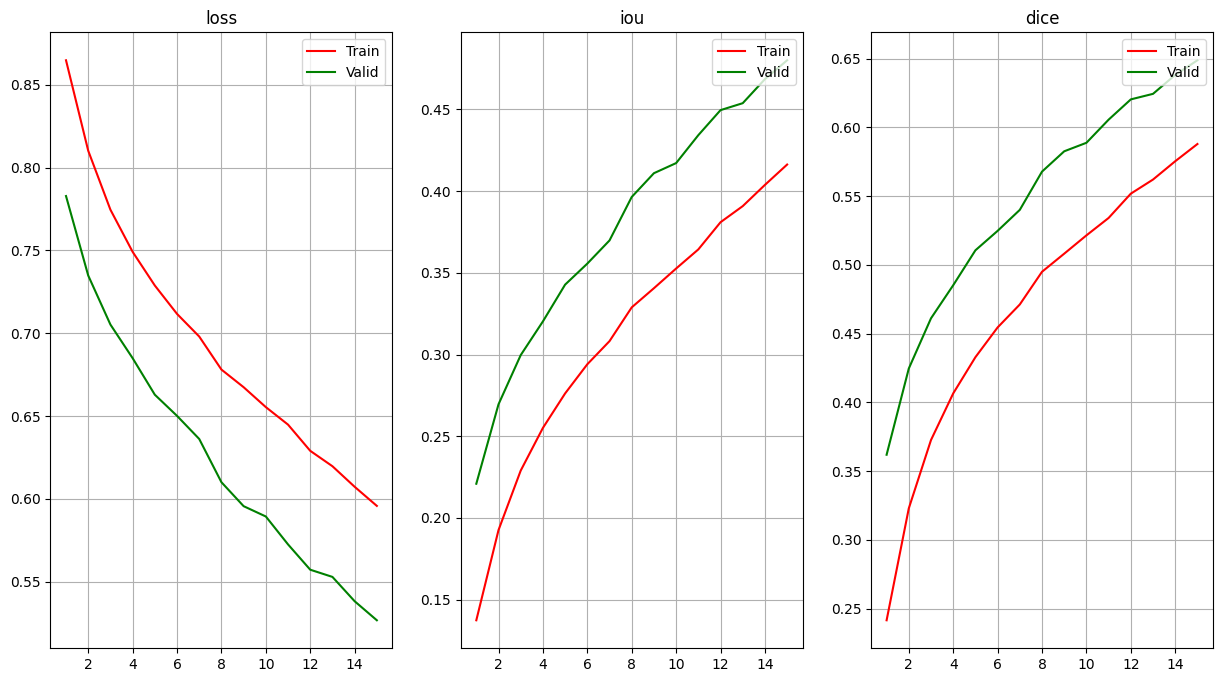

Best model metrics:
--------------------------------------------------
valid (1/1) dice: 0.6487379670143127 | dice/_macro: 0.6487379670143127 | dice/_micro: 0.6487379670143127 | iou: 0.48009780049324036 | iou/_macro: 0.48009780049324036 | iou/_micro: 0.48009780049324036 | trevsky: 0.5591716766357422 | trevsky/_macro: 0.5591716766357422 | trevsky/_micro: 0.5591716766357422
* Epoch (1/1) 


f:\housing-segmentation-in-amur-river-area\env\lib\site-packages\accelerate\utils\dataclasses.py:522: FutureWarning: The `TPU` of `<enum 'DistributedType'>` is deprecated and will be removed in v1.0.0. Please use the `XLA` instead.
  warnings.warn(


In [20]:
experiment.run_experiment()

# Тестирование модели

In [21]:
def inference_one_image(image, model, transform):
    image_tensor = image.astype(np.float32)
    #image_tensor = torch.tensor(image_tensor, device=DEVICE).permute(2, 0, 1).unsqueeze(0)
    if transform:
        augmented = transform(image=image_tensor)
        image_tensor = augmented['image'].to(DEVICE).unsqueeze(0)
    else:
        image_tensor = image_tensor.to(DEVICE).unsqueeze(0)
    model.eval()
    result_mask = model(image_tensor) > 0.5
    result_mask = result_mask.squeeze().detach().cpu().numpy()
    #result_mask = (result_mask > 0.5).astype(np.int_)
    #result_label = result_label.squeeze().detach().cpu().numpy()
    return result_mask

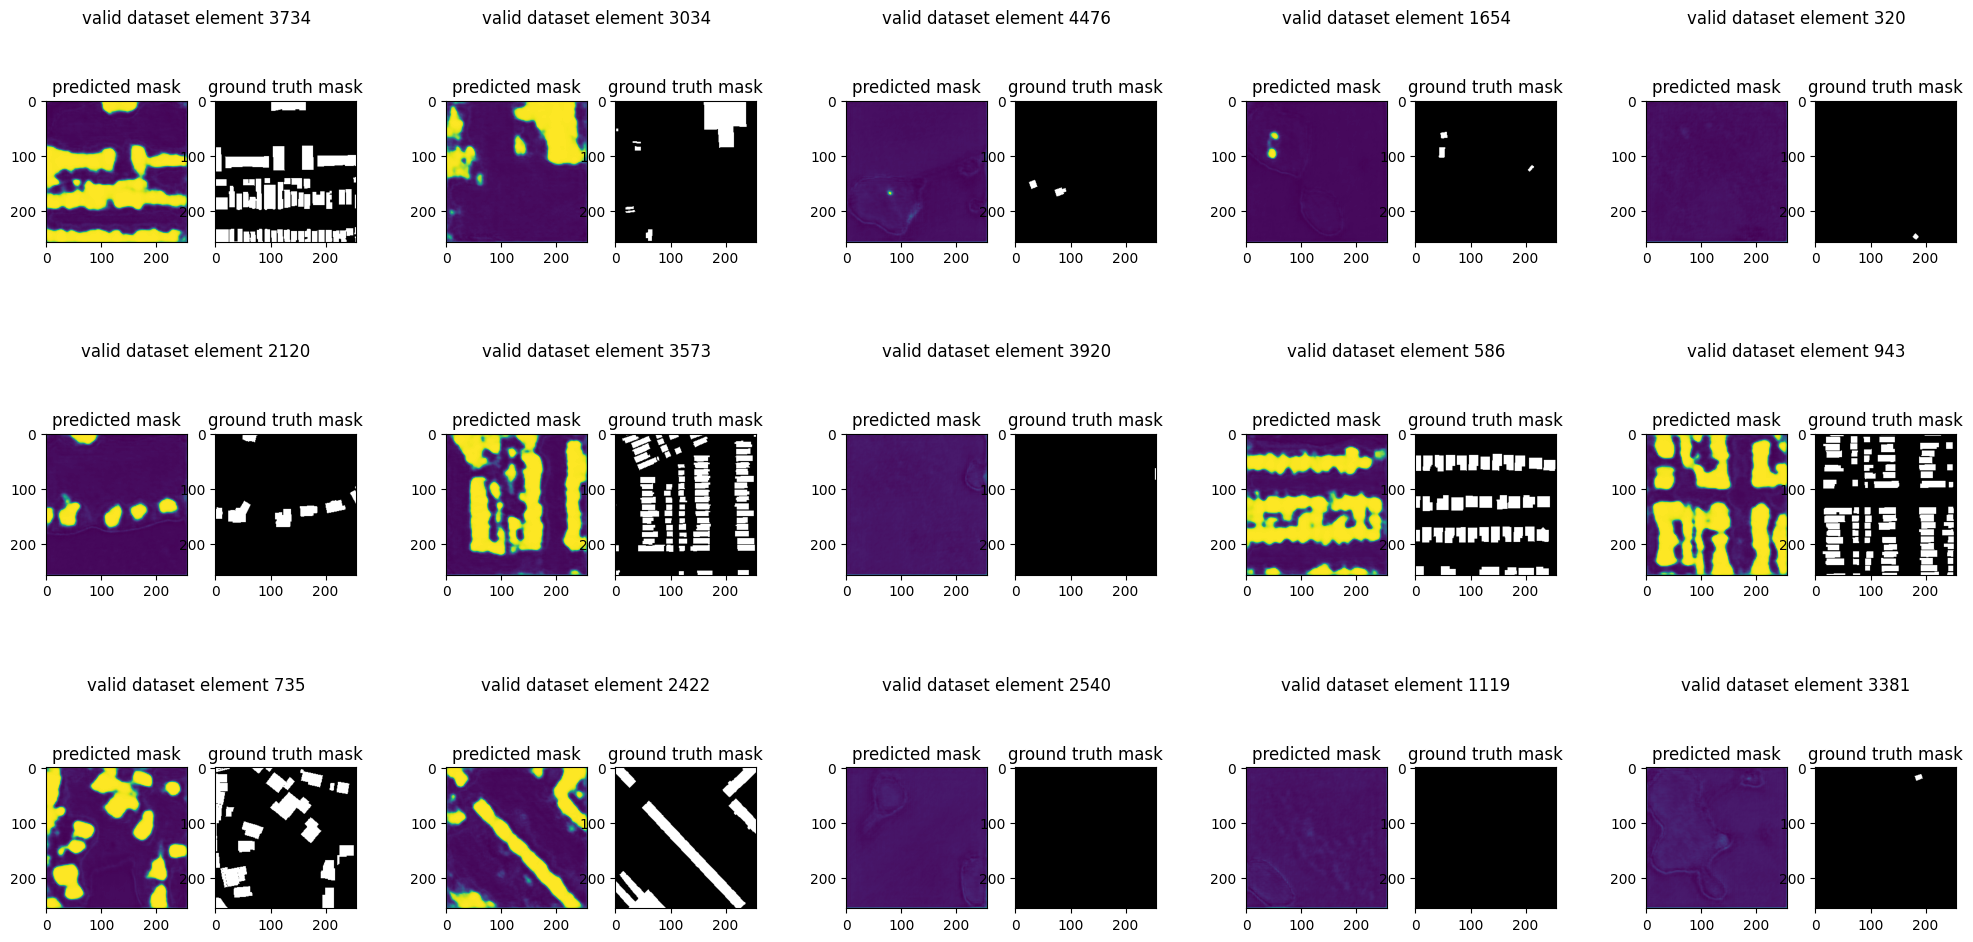

In [22]:
num_images = 15
valid_subset_numbers = random.sample(range(0, len(ds_val)), num_images)

fig = plt.figure(figsize=(20, 10))
subfigs = fig.subfigures(num_images // 5, 5)

i = 0
for outerind, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(1, 2)
    image, mask = ds_val[valid_subset_numbers[i]]['image'], ds_val[valid_subset_numbers[i]]['mask']
    subfig.suptitle(f'valid dataset element {valid_subset_numbers[i]}')

    mask_pred = model(image.to(DEVICE).float().unsqueeze(0)).detach().cpu().squeeze()
    axs[0].imshow(mask_pred)
    axs[0].set_title(f'predicted mask')
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title(f'ground truth mask')
    i += 1
plt.show()